## Handling missing values using Univariate Imputation Techniques

Missing vales in the data can be handled in different ways. One technique which is quite often used is __Imputation__. Imputation is a method where we replace null values with a certain values. 

There are two main Imputation ways, Univariate or in Multivariate. In Univariate method missing data of single column is handled based values of this column itself. While Multivariate Imputation can handle missing values depending on various column values.

Data is usually Numerical or Categorical. Numerical missing values Imputation involves:

    Mean or Median
    Arbitrary(constant)
    End of distribution

Imputation with mean or median is useful when data is Missing At Random (MCAR).i.e. data is randomly in any random rows. <br>
Imputation with arbitrary value is useful when data is not Missing At Random (NMAR). i.e., data is missing in a chunck of uniform rows. <br>
End of distribution is similar to arbitrary. Here Imputation is done using IQR proximity.

Categorical missing values are usually imputed by:

    Mode 
    Arbitrary (constant term) 

There are three more ways of imputation which can be both applicable for numerical and categorical data. <br>

    Random Sample Imputation
    Missing Indicator
    Automatically select value for impuatation

In this article we will learn few Univariate Imputation. All techniques mentioned above come under Univariate Imputation.

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from sklearn import set_config
set_config(display='diagram')

import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

In [19]:
df = pd.read_csv('./Datasets/train.csv', usecols=['Age', 'Fare', 'SibSp', 'Parch', 'Survived'])

In [20]:
df['Family'] = df['SibSp'] + df['Parch']
df.drop(columns=['SibSp', 'Parch'], inplace=True)
df.head(1)

,Survived,Age,Fare,Family
0,0,22.0,7.25,1


In [100]:
df['Age'].isnull().sum()

177

In [21]:
# percentage of missing data in each column
(df.isnull().mean())*100

Survived     0.00000
Age         19.86532
Fare         0.00000
Family       0.00000
dtype: float64

'Age' column has 19% of missing values. Let's impute the missing values.

In [95]:
# split
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## pandas fillna() 
We are using pandas fillna() function to impute null values

In [24]:
# Imputing null values with mean and median of 'Age' column and saving the data in new columns
X_train['Age Mean Impute'] = X_train['Age'].fillna(X_train['Age'].mean())
X_train['Age Median Impute'] = X_train['Age'].fillna(X_train['Age'].median())

X_train.head()

# for imputing with arbitrary code looks like this
# X_train['Age Arbit Impute'] = X_train['Age'].fillna(0) # here ) is the arbitrary value

,Age,Fare,Family,Age Mean Impute,Age Median Impute
331,45.5,28.5000,0,45.5,45.5
733,23.0,13.0000,0,23.0,23.0
382,32.0,7.9250,0,32.0,32.0
704,26.0,7.8542,1,26.0,26.0
813,6.0,31.2750,6,6.0,6.0


#### Compare change in the variance of 'Age' data after imputation
The variance value should not change drastically.

In [26]:
print(X_train['Age'].var())
print(X_train['Age Mean Impute'].var())
print(X_train['Age Median Impute'].var())

210.2517072477438
168.8519336687225
169.20731007048096


There is noticeable difference in variance of 'Age' column, which might not be a good thing. This happened because there were 20% of missing values in this column. 

#### Checking changes in distribution of the data

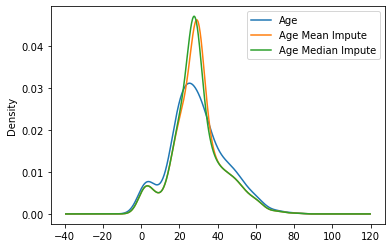

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

# actual age distribution
X_train['Age'].plot(kind='kde', ax=ax)

# age distribution after mean imputation
X_train['Age Mean Impute'].plot(kind='kde', ax=ax)

# age distribution after median imputation
X_train['Age Median Impute'].plot(kind='kde', ax=ax)

# legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

#### Check how the relation between 'Age' column has changed with other columns
It is always a good idea to check how the relationship has changed between the updated feature with other existing features. Ideally the change should be very low. That mean we have not disturbed the data distribution. There are two ways to check the relationship. One is by checking covariance the other is by checking correlation.

In [32]:
# covariance
X_train.cov()

,Age,Fare,Family,Age Mean Impute,Age Median Impute
Age,210.251707,71.580633,-6.993325,210.251707,210.251707
Fare,71.580633,2700.831981,18.495747,57.485994,61.261919
Family,-6.993325,18.495747,2.830892,-5.616299,-5.587710
Age Mean Impute,210.251707,57.485994,-5.616299,168.851934,168.851934
Age Median Impute,210.251707,61.261919,-5.587710,168.851934,169.207310


In [33]:
# correlation
X_train.corr()

,Age,Fare,Family,Age Mean Impute,Age Median Impute
Age,1.000000,0.088103,-0.319651,1.000000,1.000000
Fare,0.088103,1.000000,0.211525,0.085126,0.090622
Family,-0.319651,0.211525,1.000000,-0.256883,-0.255307
Age Mean Impute,1.000000,0.085126,-0.256883,1.000000,0.998949
Age Median Impute,1.000000,0.090622,-0.255307,0.998949,1.000000


In covariance we can see the change is values is kind of high. This might be a red flag. It is good to say we checked the relationship before going ahead with these changes.

#### Box plot

Box plot is a great way to detect outliers

<AxesSubplot:>

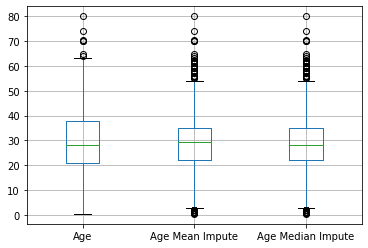

In [37]:
X_train[['Age', 'Age Mean Impute', 'Age Median Impute']].boxplot()

There are more outliers now after imputation. This has happened because there are large number of missing values.

## SimpleImputer()
We are imputing using scikit learn library class SimpleImputer().

I'm also using ColumnTransformer(). This will be helpful when we want to change multiple columns at once. You will see how.

In [48]:
# create dataframe
df = pd.read_csv('./Datasets/train.csv', usecols=['Age', 'Fare', 'SibSp', 'Parch', 'Survived'])
df['Family'] = df['SibSp'] + df['Parch']
df.drop(columns=['SibSp', 'Parch'], inplace=True)

# split
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I have repeated above steps as while using pandas method for imputation, I hanged the dataframe by adding new columns, which we don't need here.

In [49]:
trf = ColumnTransformer(transformers=[('age_mean', SimpleImputer(strategy='mean'), ['Age']),
                                      ('age_median', SimpleImputer(strategy='median'), ['Age'])],
                        remainder='passthrough')

# for imputing with arbitraty the code is as follows, filling with 0
# trf = ColumnTransformer(transformers=[('age_arbit',SimpleImputer(strategy='constant', fill_value=0),['Age'])],
#                         remainder='passthrough')

So, let's check what mean and median values our algorithm used for imputation.

In [55]:
print('mean: ', trf.named_transformers_['age_mean'].statistics_)
print('median: ', trf.named_transformers_['age_median'].statistics_)

mean:  [29.49884615]
median:  [28.]


In [58]:
# fitting the algorith on the train and test data
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [59]:
X_train_trf

array([[ 45.5   ,  45.5   ,  28.5   ,   0.    ],
       [ 23.    ,  23.    ,  13.    ,   0.    ],
       [ 32.    ,  32.    ,   7.925 ,   0.    ],
       ...,
       [ 41.    ,  41.    ,  14.1083,   2.    ],
       [ 14.    ,  14.    , 120.    ,   3.    ],
       [ 21.    ,  21.    ,  77.2875,   1.    ]])

## Random Sample Imputation

In [121]:
df = pd.read_csv('./Datasets/train.csv', usecols=['Age', 'Fare', 'Survived'])

In [122]:
# split
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We are creating a new column with same values of Age column. To show you how the values look after Ransom Sample Imputation

In [123]:
X_train['AgeImputed'] = X_train['Age'] 
X_test['AgeImputed'] = X_test['Age'] 

In [124]:
# count of null values
X_train['AgeImputed'].isnull().sum()

140

In [125]:
# we are replacing null values of the column with random values(not null of course) of the same column. 
# make sure count of values you are extracting is same as count of null values.
# you can use Age column or AgeImputed column to choose values. As both columns have same values

X_train['AgeImputed'][X_train['AgeImputed'].isnull()] = X_train['Age'].dropna().sample(X_train['Age'].isnull().sum()).values
X_test['AgeImputed'][X_test['AgeImputed'].isnull()] = X_test['Age'].dropna().sample(X_test['Age'].isnull().sum()).values

Now let's check how the changes look. Let's compare only null rows of Age and AgeImputed columns 

In [126]:
X_train[['Age', 'AgeImputed']][X_train['Age'].isnull()]

,Age,AgeImputed
29,NaN,19.0
55,NaN,32.0
533,NaN,18.0
495,NaN,20.0
468,NaN,17.0
...,...,...
330,NaN,14.0
214,NaN,10.0
466,NaN,40.0
121,NaN,62.0


We can see the null values of AgeImputed column are replaced of random values of same column

### Plotting to compare distribution

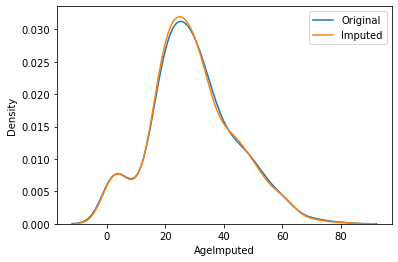

In [138]:
sns.distplot(X_train['Age'], label='Original', hist=False)
sns.distplot(X_train['AgeImputed'], label='Imputed', hist=False)

plt.legend()
plt.show()

So, the distribution is similar.

### Variance

In [139]:
print(X_train['Age'].var())
print(X_train['AgeImputed'].var())

210.2517072477438
205.59528554417665


Not much difference in variance

### Covariance

In [146]:
X_train[['Age','AgeImputed','Fare']].cov()

,Age,AgeImputed,Fare
Age,210.251707,210.251707,71.580633
AgeImputed,210.251707,205.595286,54.193541
Fare,71.580633,54.193541,2700.831981


Covariance with other columns changed

### Box plot

<AxesSubplot:>

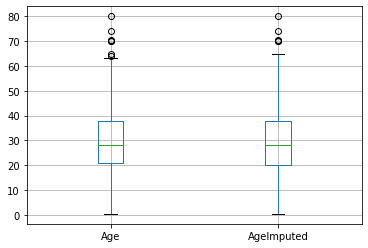

In [141]:
X_train[['Age', 'AgeImputed']].boxplot()

Outliers are not much impacted, look same.

Since missing values were low for this column, this Random Sample imputation method worked well here.

In [148]:
# The following code helps to get sample age value from 'Age' column for the 'Fare' value provided. 
# Data looks more consistent this way.
# sampled_value = X_train['Age'].dropna().sample(1, random_state=int(observation['Fare']))

## Missing Indicator

In [151]:
df = pd.read_csv('./Datasets/train.csv', usecols=['Age', 'Fare', 'Survived'])

# split
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Accuracy before using MissingIndicator

In [154]:
# tranformer object
SI = SimpleImputer()

# transform
X_train_trf = SI.fit_transform(X_train)
X_test_trf = SI.transform(X_test)

# model object
LR = LogisticRegression()

# train
LR.fit(X_train_trf, y_train)

#predict
y_pred = LR.predict(X_test_trf)

# accuracy
accuracy_score(y_test, y_pred)

0.6480446927374302

#### Accuracy after using MissingIndicator

In [155]:
# MissingIndicator() object
MI = MissingIndicator()

# fit
X_train_missing = MI.fit_transform(X_train)
X_test_missing = MI.transform(X_test)

In [217]:
X_train_missing

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [159]:
X_train['AgeNullIndicator'] = X_train_missing
X_test['AgeNullIndicator'] = X_test_missing

So, what I have done is I created a new column in input train data and added the array that we got after fitting the MI model on input train data. And I did the same with input test data also

In [161]:
# checking how the dataset looks
print(X_train.head(2))
print(X_test.head(2))

      Age  Fare  AgeNullIndicator
331  45.5  28.5             False
733  23.0  13.0             False
      Age     Fare  AgeNullIndicator
709   NaN  15.2458              True
439  31.0  10.5000             False


In [163]:
# SimpleImputer object
SI = SimpleImputer()

# to avoid using MissingIndicator and help yourself with cutting some steps down(no need for new columns), 
# you can do following 
# SI = SimpleImputer(add_indicator=True) # this will turn on your indicator

# fit
X_train_trf = SI.fit_transform(X_train)
X_test_trf = SI.transform(X_test)

# model object
LR = LogisticRegression()

# fit
LR.fit(X_train_trf, y_train)

# predict
y_pred = LR.predict(X_test_trf)

# accuracy
accuracy_score(y_test, y_pred)

0.6368715083798883

## Automatically Select value for Imputation

In [195]:
df = pd.read_csv('./Datasets/train.csv', usecols=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])

In [196]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [197]:
# split
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [198]:
# separating numerical and categorical features
numerical_features = ['Age', 'Fare']
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())])

categorical_features = ['Embarked', 'Sex']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [199]:
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features),
                                               ('cat', categorical_transformer, categorical_features)],
                                 remainder='passthrough')

In [209]:
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())])

In [219]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked', 'Sex'])])),
                ('classifier', LogisticRegression())])

In [211]:
param_grid = {'preprocessor__num__imputer__strategy':['mean', 'median'],
              'preprocessor__cat__imputer__strategy':['most_frequent', 'constant'],
              'classifier__C':[0.1,1.0,10,100]
             }
grid_search = GridSearchCV(pipe, param_grid, cv=10)

In [213]:
grid_search.fit(X_train, y_train)
print(f"Best params: ")
print(grid_search.best_params_)

Best params: 
{'classifier__C': 1.0, 'preprocessor__cat__imputer__strategy': 'constant', 'preprocessor__num__imputer__strategy': 'median'}


In [215]:
# you can check and compare the result
cv_results = pd.DataFrame(grid_search.cv_results_)

cv_results 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_preprocessor__cat__imputer__strategy,param_preprocessor__num__imputer__strategy,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020446,0.007972,0.009073,0.011744,0.1,most_frequent,mean,"{'classifier__C': 0.1, 'preprocessor__cat__imp...",0.847222,0.763889,...,0.915493,0.84507,0.732394,0.760563,0.718310,0.718310,0.915493,0.793505,0.076136,14
1,0.018742,0.006249,0.004688,0.007162,0.1,most_frequent,median,"{'classifier__C': 0.1, 'preprocessor__cat__imp...",0.847222,0.777778,...,0.915493,0.84507,0.732394,0.760563,0.704225,0.718310,0.915493,0.793486,0.077235,16
2,0.017178,0.004694,0.007819,0.007819,0.1,constant,mean,"{'classifier__C': 0.1, 'preprocessor__cat__imp...",0.847222,0.763889,...,0.915493,0.84507,0.732394,0.760563,0.718310,0.718310,0.915493,0.793505,0.076136,14
3,0.018152,0.006818,0.007186,0.009163,0.1,constant,median,"{'classifier__C': 0.1, 'preprocessor__cat__imp...",0.847222,0.777778,...,0.915493,0.84507,0.732394,0.760563,0.718310,0.718310,0.915493,0.794894,0.075708,6
4,0.019190,0.006971,0.010075,0.007068,1.0,most_frequent,mean,"{'classifier__C': 1.0, 'preprocessor__cat__imp...",0.847222,0.791667,...,0.915493,0.84507,0.732394,0.760563,0.718310,0.732394,0.901408,0.794875,0.073643,7
5,0.019278,0.006195,0.007809,0.007809,1.0,most_frequent,median,"{'classifier__C': 1.0, 'preprocessor__cat__imp...",0.847222,0.791667,...,0.915493,0.84507,0.732394,0.760563,0.718310,0.732394,0.901408,0.794875,0.073643,7
6,0.025080,0.005519,0.004288,0.002993,1.0,constant,mean,"{'classifier__C': 1.0, 'preprocessor__cat__imp...",0.847222,0.791667,...,0.915493,0.84507,0.732394,0.760563,0.718310,0.732394,0.901408,0.794875,0.073643,7
7,0.025450,0.006323,0.005414,0.005729,1.0,constant,median,"{'classifier__C': 1.0, 'preprocessor__cat__imp...",0.847222,0.791667,...,0.915493,0.84507,0.732394,0.760563,0.718310,0.732394,0.915493,0.796283,0.075771,1
8,0.016044,0.006103,0.009791,0.008084,10,most_frequent,mean,"{'classifier__C': 10, 'preprocessor__cat__impu...",0.847222,0.791667,...,0.929577,0.84507,0.732394,0.760563,0.718310,0.732394,0.901408,0.796283,0.076032,1
9,0.021872,0.010353,0.007810,0.007810,10,most_frequent,median,"{'classifier__C': 10, 'preprocessor__cat__impu...",0.847222,0.791667,...,0.915493,0.84507,0.732394,0.760563,0.718310,0.732394,0.901408,0.794875,0.073643,7


## Summary
In this notebook we have covered various Univariate imputation techniques to handle missing values.